In [1]:
import openmc
import numpy as np
import time

In [8]:
#mats taken from openmc triso example https://github.com/openmc-dev/openmc/wiki/Example-Jupyter-Notebooks
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.5)
fuel.add_nuclide('U235', 4.6716e-02)
fuel.add_nuclide('U238', 2.8697e-01)
fuel.add_nuclide('O16',  5.0000e-01)
fuel.add_element('C', 1.6667e-01)

PyC = openmc.Material(name='PyC1')
PyC.set_density('g/cm3', 1.9)
PyC.add_element('C', 1.0)
PyC.add_s_alpha_beta('c_Graphite')

graphite = openmc.Material()
graphite.set_density('g/cm3', 1.1995)
graphite.add_element('C', 1.0)
graphite.add_s_alpha_beta('c_Graphite')

he = openmc.Material(name='He')
he.set_density('atom/b-cm', 0.0006) #'atom/b-cm', 0.0006
he.add_element('He', 1.0)

peb_or = 0.5
peb_ir = 0.45
kernel_or = 0.04225
kernel_ir = 0.0215
core_r = 5.0
core_h = 10.0
reflector_t = core_r*0.3

peb_wfuel = openmc.Sphere(r=peb_ir)
peb_wfuel_outer = -peb_wfuel

sphere_kern = openmc.Sphere(r=kernel_ir)
cell = [openmc.Cell(fill=fuel, region = -sphere_kern), openmc.Cell(fill=PyC, region=+sphere_kern)]
triso_univ = openmc.Universe(cells=cell)

centers = openmc.model.pack_spheres(kernel_or, region=peb_wfuel_outer, pf=0.1)
trisos = [openmc.model.TRISO(kernel_or, triso_univ, center) for center in centers]
print(centers) #this is the positions of the TRISO pebbles themselves

peb_nofuel = openmc.Sphere(r=peb_or)
peb_nofuel_zone_outer = -peb_nofuel
peb_nofuel_zone_inner = +peb_wfuel
peb_fuel_zone = -peb_wfuel

sphere = openmc.Cell(region=peb_wfuel_outer)
lower_left, upper_right = sphere.region.bounding_box
shape = (5, 5, 5)
pitch = (upper_right - lower_left)/shape
lattice = openmc.model.create_triso_lattice(
    trisos, lower_left, pitch, shape, graphite)

sphere.fill = lattice

pebble_element = [sphere,
              openmc.Cell(fill=graphite, region=peb_nofuel_zone_inner & peb_nofuel_zone_outer)]
pebble_univ = openmc.Universe(cells=pebble_element)
active_core_sides = openmc.ZCylinder(r = core_r)
active_core_top = openmc.ZPlane(z0=(core_h/2))
active_core_bot = openmc.ZPlane(z0=-(core_h/2))
active_core_bound = -active_core_sides & -active_core_top & +active_core_bot

[[-2.65142102e-01  1.60627678e-01  8.45606260e-03]
 [-3.14071113e-01  1.49264829e-01  1.72415407e-01]
 [-2.03109762e-01 -1.51113101e-01 -1.87919928e-01]
 [-1.38995436e-01  2.27215423e-01 -3.03517655e-01]
 [ 4.17217394e-02  1.11559068e-01  2.62708076e-01]
 [-6.80571249e-03 -1.75669545e-01 -2.49598281e-01]
 [-1.22224267e-01 -2.30061223e-01 -8.13368625e-02]
 [ 7.07591479e-02 -1.93874087e-01 -3.21451844e-01]
 [ 5.28553606e-02  2.70507011e-01  2.93173120e-01]
 [ 2.63933227e-01 -6.08152936e-02  2.34897952e-01]
 [-1.22268657e-01  3.49278298e-02  2.50339446e-01]
 [ 2.70513447e-01  4.37424206e-02 -7.05957036e-03]
 [ 1.11322114e-01  5.77647182e-02  1.46302615e-01]
 [-7.46016808e-02 -3.78950142e-02 -3.19053619e-01]
 [ 6.29215263e-02 -2.94757835e-01 -1.45211542e-01]
 [ 2.96340374e-01 -1.61077123e-01  1.98967695e-01]
 [-1.72908877e-01  2.91648904e-01  1.06592230e-01]
 [ 1.22734074e-01 -2.56900561e-01 -2.64980545e-01]
 [ 1.23249964e-01 -6.00942297e-02  1.93402462e-01]
 [ 2.87351274e-01  2.10912206e-

In [4]:
print("starting openmc pack")
start_time = time.perf_counter()
peb_centers = openmc.model.pack_spheres(peb_or, region=active_core_bound, pf = .40, contraction_rate = 0.0001)
print(time.perf_counter()-start_time)

pebs = [openmc.model.TRISO(peb_or, pebble_univ, peb_center) for peb_center in peb_centers]

peb_centertest = np.vstack([peb.center for peb in pebs])
print(peb_centertest.min(axis=0))
print(peb_centertest.max(axis=0))

inner_core = openmc.Cell(region=active_core_bound)
lower_left_core, upper_right_core = inner_core.region.bounding_box
shape_core = (5, 5, 5)
pitch_core = (upper_right_core - lower_left_core)/shape_core
core_lattice = openmc.model.create_triso_lattice(
    pebs, lower_left_core, pitch_core, shape_core, he)

inner_core.fill=core_lattice

starting openmc pack
3.4720230840030126
[-4.49994518 -4.49996232 -4.5       ]
[4.49993091 4.49999097 4.5       ]


In [5]:
outer_reflector_sides = openmc.ZCylinder(r = (core_r+reflector_t), boundary_type='vacuum')
outer_reflector_top = openmc.ZPlane(z0=((core_h/2)+reflector_t),boundary_type='vacuum')
outer_reflector_bot = openmc.ZPlane(z0=-((core_h/2)+reflector_t),boundary_type='vacuum')
reflector_outer = -outer_reflector_sides & -outer_reflector_top & +outer_reflector_bot
reflector_bounds = reflector_outer | active_core_bound
reflector = openmc.Cell(region = reflector_bounds, fill = graphite)

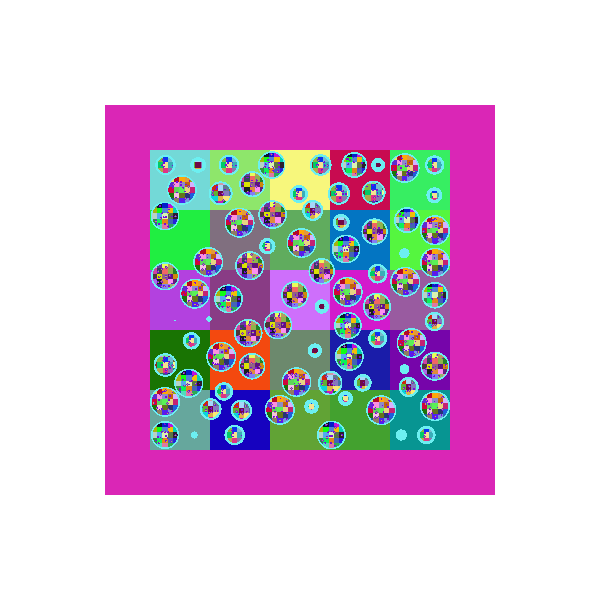

In [6]:
universe = openmc.Universe(cells=[inner_core, reflector])

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

materials = list(geometry.get_all_materials().values())
openmc.Materials(materials).export_to_xml()

settings = openmc.Settings()
settings.run_mode = 'plot'
settings.export_to_xml()

#mc.plot_geometry()
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xz'
plot.width = (core_r*4, core_h*2)
plot.pixels = (600, 600)
plot.to_ipython_image()
#mc.plot_inline(plot)

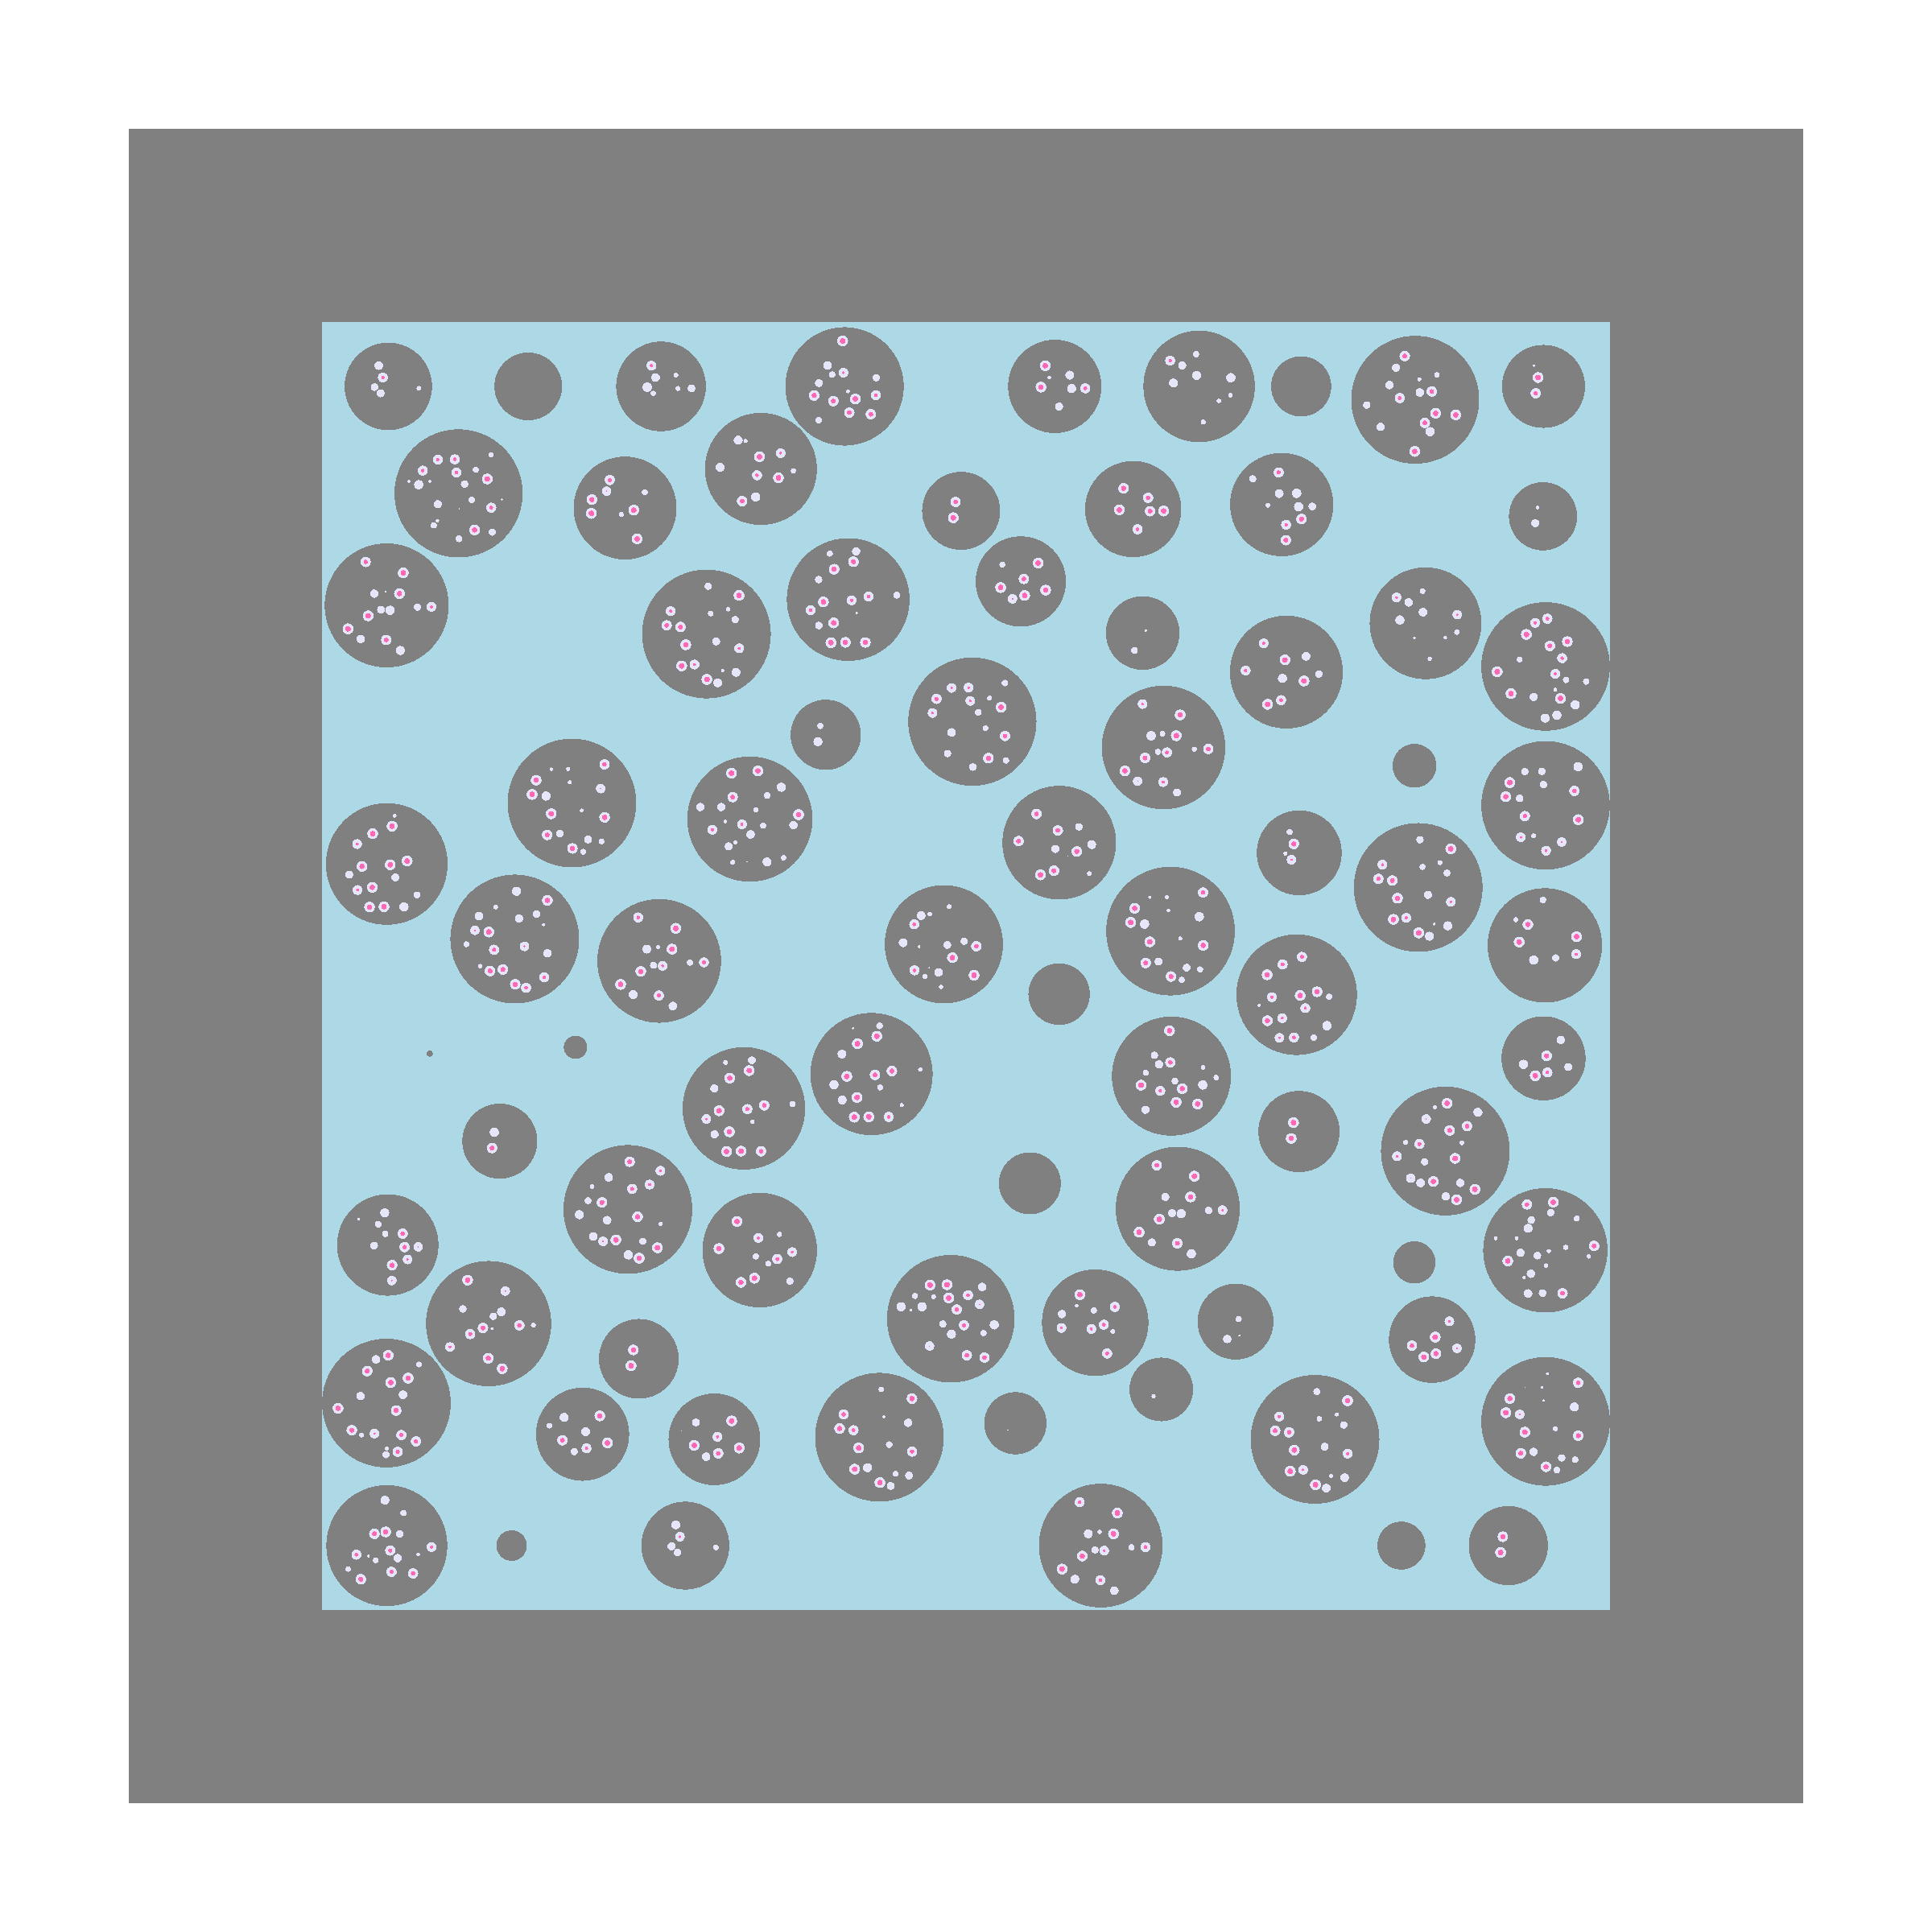

In [7]:
plot.color_by = 'material'
plot.colors = {graphite: 'gray', he: 'lightblue', fuel: 'hotpink', PyC: 'lavender'}
plot.width = (core_r*3, core_h*1.5)
plot.pixels = (2400, 2400)
plot.to_ipython_image()